<a href="https://colab.research.google.com/github/dpriyabijosh/Depression_detection/blob/main/XLNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-transformers # For Colab 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.4 MB/s 
     |████████████████████████████████| 1.3 MB 58.1 MB/s 
     |████████████████████████████████| 132 kB 65.0 MB/s 
     |████████████████████████████████| 880 kB 55.7 MB/s 
     |████████████████████████████████| 79 kB 10.2 MB/s 
     |████████████████████████████████| 10.2 MB 38.4 MB/s 
     |████████████████████████████████| 140 kB 83.8 MB/s 
     |████████████████████████████████| 127 kB 82.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=eadd4909c90d038389e7b15ea7f652da7e33a1fd2cb60f5f1cd1a5f17081534c
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstall

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data_original = pd.read_csv('drive/My Drive/sentiment_tweets3.csv')
data = data_original.drop(data_original.columns[[0]],axis = 1)
#Rename the columns
data.rename(columns={'message to examine' :'tweet','label (depression result)': 'label'},inplace=True)

Mounted at /content/drive


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# if torch.cuda.is_available():       
#     device = torch.device("cuda")
#     print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#     print('Device name:', torch.cuda.get_device_name(0))

# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [ ]:
!pip install sentencepiece 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 78.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.6 MB/s 


In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 4.6 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.25.1



##Import libraries

In [ ]:
import pandas as pd
import re
import os
import math
import torch
# import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, NLLLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import unicodedata
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score
import seaborn as sns
import itertools
import plotly
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter  
%matplotlib inline

In [ ]:
data

,tweet,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


In [ ]:
from transformers import XLNetTokenizer, XLNetLMHeadModel
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')

# We show how to setup inputs to predict a next token using a bi-directional context.
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is very <mask>", add_special_tokens=False)).unsqueeze(0)  # We will predict the masked token
perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
perm_mask[:, :, -1] = 1.0  # Previous tokens don't see last token
target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)  # Shape [1, 1, seq_length] => let's predict one token
target_mapping[0, 0, -1] = 1.0  # Our first (and only) prediction will be the last token of the sequence (the masked token)


Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

token_lens = []

for txt in data['tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))


data["token_length"]  = token_lens

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
train ,test = train_test_split(data, random_state=2018, test_size=0.2)

print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 8,251

Number of testing sentences: 2,063



In [1]:
sentences = train.tweet.values
labels = train.label.values
sentences[0:5]

## Tokenization and Input Formatting

The XLNetTokenizer and the pretrained cased version of the XLNetModel from huggingface is loaded here. The tokenizer inherits from PreTrainedTokenizer which contains most of the main methods. This model is also a PyTorch torch.nn.Module subclass and can be used as a regular pytroch module. The Tensorflow equivalent is the TFXLNetModel.

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [ ]:
#Checking the tokenization with a single sentence
print(' Original sentence {}: '.format( sentences[1]))


print('Tokenized sentence {}:  '.format(tokenizer.tokenize(sentences[1])))

# Print the tweet mapped to token ids.
print('Token IDs  {}: '.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1]))))

 Original sentence @cazp09 aww cool  bet your all excited  has em got a preference ? xx: 
Tokenized sentence ['▁', '@', 'ca', 'z', 'p', '09', '▁a', 'ww', '▁cool', '▁bet', '▁your', '▁all', '▁excited', '▁has', '▁em', '▁got', '▁a', '▁preference', '▁', '?', '▁', 'xx']:  
Token IDs  [17, 13304, 1346, 553, 450, 3844, 24, 24225, 2299, 9131, 73, 71, 5564, 51, 10519, 345, 24, 12150, 17, 82, 17, 17735]: 


###Tokenize Dataset

XLNet model has several inputs which is fed to.

inputs_ids : Indices of input sequence(Integer Id's) tokens in the vocabulary generated by tokenizer.

token_type_ids : Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]: 0 represents sentence A and 1 for B.

attention_mask : Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]. 1 for not masked and 0 for masked.

labels: a single value of 1 or 0. For our data depressive is 1 and non-depressive 0.

To format inputs arrays to be the same length as required by XLNet, we can specify a maximum sequence length then pad sequences with length less this maximum with zeros.Sequences with lengths greater than the maximum is truncated. The paading short sequences and truncating longer sequences at the maximum length specified formats all the input arrays to the same size.

In [ ]:
#def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
attention_masks = create_attn_masks(input_ids)

# Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
input_ids = torch.from_numpy(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs:', input_ids[1])
print('Token IDs:', attention_masks[1])

Original:  @cazp09 aww cool  bet your all excited  has em got a preference ? xx
Token IDs: tensor([   17, 13304,  1346,   553,   450,  3844,    24, 24225,  2299,  9131,
           73,    71,  5564,    51, 10519,   345,    24, 12150,    17,    82,
           17, 17735,     4,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  

##Training & Validation Split¶

Divide up our training set to use 80% for training and 20% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with depression'.format(sum(label_temp_list)))

label_temp_list = []
for a,b,c in val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with depression'.format(sum(label_temp_list)))

6,600 training samples
1,488 training samples with real news
1,651 validation samples
  361 validation samples with real news


The PyTorch torch.utils.data.DataLoader class Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. Batch size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Fine - Tuning our Classification Model



In [ ]:
from torch.nn import BCEWithLogitsLoss, NLLLoss
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
       
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids
                                  )
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
   
    logits = logits[:, 1] - logits[:, 0]
    if labels is not None:

      loss = BCEWithLogitsLoss()(logits, labels.float())
#      
    
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
   

In [ ]:
model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))

An optimizer with weight decay fixed that can be used to fine-tuned models. SO we use torch.optim.AdamW optimizer.

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

####Training the model.
Unpack our data inputs and labels. Load data onto the GPU for acceleration. Forward pass (feed input data through the network). Compute loss on our validation data and track variables for monitoring progress.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """
  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []
  # Measure the total training time for the whole run.
  total_t0 = time.time()

  model.to(device)

  # trange is a tqdm wrapper around the python range function
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
   

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set. 
    print("")
    print('======== Epoch {:} / {:} ========'.format(actual_epoch, num_epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0: 
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store train loss
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

#     print("Train loss: {}".format(epoch_train_loss))
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(epoch_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            # store valid loss
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

#     print("Valid loss: {}".format(epoch_eval_loss))
    
    # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(epoch_eval_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': actual_epoch,
            'Training Loss': epoch_train_loss,
            'Valid. Loss': epoch_eval_loss,
#             'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    
    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
  
  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, train_loss_set, valid_loss_set, training_stats 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
save_path = '/content/drive/MyDrive/NLP/Xlnet'


In [ ]:
# function to save and load the model form a specific epoch
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist,\
                'optimizer_state_dict': optimizer.state_dict()
               }
               
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist  


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
num_epochs = 5

cwd = os.getcwd()

model_save_path = output_model_file = "/content/drive/MyDrive/Colab Notebooks/NLP/Xlnet/xlnet.bin"



model, train_loss_set, valid_loss_set, training_stats = train(model=model,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=model_save_path,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 0 / 5 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:19.
  Batch    80  of    413.    Elapsed: 0:00:39.
  Batch   120  of    413.    Elapsed: 0:00:58.
  Batch   160  of    413.    Elapsed: 0:01:16.
  Batch   200  of    413.    Elapsed: 0:01:35.
  Batch   240  of    413.    Elapsed: 0:01:54.
  Batch   280  of    413.    Elapsed: 0:02:12.
  Batch   320  of    413.    Elapsed: 0:02:31.
  Batch   360  of    413.    Elapsed: 0:02:50.
  Batch   400  of    413.    Elapsed: 0:03:08.

  Average training loss: 0.00
  Training epcoh took: 0:03:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:18


Epoch:  20%|██        | 1/5 [03:37<14:30, 217.73s/it]

Saving model at epoch 0 with validation loss of 0.00011057139429424177

======== Epoch 1 / 5 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:19.
  Batch    80  of    413.    Elapsed: 0:00:38.
  Batch   120  of    413.    Elapsed: 0:00:57.
  Batch   160  of    413.    Elapsed: 0:01:15.
  Batch   200  of    413.    Elapsed: 0:01:34.
  Batch   240  of    413.    Elapsed: 0:01:52.
  Batch   280  of    413.    Elapsed: 0:02:11.
  Batch   320  of    413.    Elapsed: 0:02:30.
  Batch   360  of    413.    Elapsed: 0:02:49.
  Batch   400  of    413.    Elapsed: 0:03:07.

  Average training loss: 0.00
  Training epcoh took: 0:03:13

Running Validation...


Epoch:  40%|████      | 2/5 [07:08<10:41, 213.91s/it]

  Validation Loss: 0.00
  Validation took: 0:00:18

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:19.
  Batch    80  of    413.    Elapsed: 0:00:37.
  Batch   120  of    413.    Elapsed: 0:00:56.
  Batch   160  of    413.    Elapsed: 0:01:15.
  Batch   200  of    413.    Elapsed: 0:01:33.
  Batch   240  of    413.    Elapsed: 0:01:52.
  Batch   280  of    413.    Elapsed: 0:02:11.
  Batch   320  of    413.    Elapsed: 0:02:29.
  Batch   360  of    413.    Elapsed: 0:02:48.
  Batch   400  of    413.    Elapsed: 0:03:06.

  Average training loss: 0.00
  Training epcoh took: 0:03:12

Running Validation...


Epoch:  60%|██████    | 3/5 [10:39<07:04, 212.20s/it]

  Validation Loss: 0.00
  Validation took: 0:00:18

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:19.
  Batch    80  of    413.    Elapsed: 0:00:37.
  Batch   120  of    413.    Elapsed: 0:00:56.
  Batch   160  of    413.    Elapsed: 0:01:15.
  Batch   200  of    413.    Elapsed: 0:01:33.
  Batch   240  of    413.    Elapsed: 0:01:52.
  Batch   280  of    413.    Elapsed: 0:02:11.
  Batch   320  of    413.    Elapsed: 0:02:29.
  Batch   360  of    413.    Elapsed: 0:02:48.
  Batch   400  of    413.    Elapsed: 0:03:07.

  Average training loss: 0.00
  Training epcoh took: 0:03:13

Running Validation...


Epoch:  80%|████████  | 4/5 [14:09<03:31, 211.55s/it]

  Validation Loss: 0.00
  Validation took: 0:00:18

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    413.    Elapsed: 0:00:19.
  Batch    80  of    413.    Elapsed: 0:00:37.
  Batch   120  of    413.    Elapsed: 0:00:56.
  Batch   160  of    413.    Elapsed: 0:01:15.
  Batch   200  of    413.    Elapsed: 0:01:33.
  Batch   240  of    413.    Elapsed: 0:01:52.
  Batch   280  of    413.    Elapsed: 0:02:11.
  Batch   320  of    413.    Elapsed: 0:02:29.
  Batch   360  of    413.    Elapsed: 0:02:48.
  Batch   400  of    413.    Elapsed: 0:03:06.

  Average training loss: 0.00
  Training epcoh took: 0:03:12

Running Validation...


Epoch: 100%|██████████| 5/5 [17:40<00:00, 212.01s/it]

  Validation Loss: 0.00
  Validation took: 0:00:18

Training complete!
Total training took 0:17:41 (h:mm:ss)


In [ ]:
#A common PyTorch convention is to save models using either a .pt or .pth file extension.
#saving method which works
save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Xlnet/xlnet.pth'


torch.save(model.state_dict(), save_path)

device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))
model.load_state_dict(torch.load(save_path))
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedFor

### Training Evaluation

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
0,3.27e-03,1.11e-04,0:03:14,0:00:18
1,7.56e-04,4.69e-04,0:03:13,0:00:18
2,2.95e-04,1.19e-04,0:03:12,0:00:18
3,4.51e-04,3.74e-04,0:03:13,0:00:18
4,4.22e-04,3.11e-04,0:03:12,0:00:18


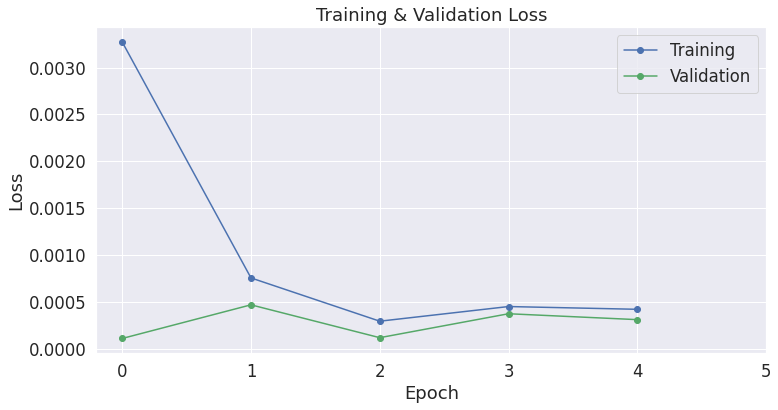

In [ ]:
#  Plot loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/NLP/Xlnet/file3.png')
plt.show()

####Get Predictions

In [ ]:
import os
import pandas as pd
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Colab Notebooks"
os.chdir(path)
# Load data and set labels
test_data_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/validation_data.csv', 
                        dtype= {'raw_tweet': str, 'label':int}, nrows=500,  usecols=[0,1])
#Rename the columns
test_data_raw.rename(columns={'raw_tweet' :'tweet'},inplace=True)

test_data_raw.head()

Mounted at /content/drive


,tweet,label
0,@_TASOfficial_ I really miss XYZ since 2016 i ...,1
1,There's not much an 8 mile depression run can'...,1
2,How to Overcome Depression#WednesdayThoughts #...,0
3,Real Talk #Kanye has never pulled himself full...,0
4,@andrea_r so it would seem. Good if you wanted...,0


In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import preprocessor as p
from tqdm.notebook import tqdm
tqdm.pandas()
# Tweet pre-processing
def tweet_preprocessing(text):
  text = text.replace("#","")

  # Replace '&amp;' with '&'
  text = re.sub(r'&amp;', '&', text)

  # Remove trailing whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  text = p.clean(text)

  return text

test_data = test_data_raw.copy()

test_data['tweet'] = test_data_raw.tweet.apply(tweet_preprocessing)

In [ ]:
test_data.head()

,tweet,label
0,I really miss XYZ since i have Post anime depr...,1
1,There's not much an mile depression run can't ...,1
2,How to Overcome DepressionWednesdayThoughts ap...,0
3,Real Talk Kanye has never pulled himself fully...,0
4,so it would seem. Good if you wanted your own ...,0


In [ ]:
from transformers import XLNetTokenizer, XLNetLMHeadModel
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [ ]:
# Get the lists of sentences and their labels
sentences = test_data.tweet.values

# input_ids = torch.from_numpy(input_ids)
# attention_masks = torch.tensor(attention_masks)
# labels = torch.tensor(labels)


test_input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
test_attention_masks = create_attn_masks(test_input_ids)

test_data["features"] = test_input_ids.tolist()
test_data["masks"] = test_attention_masks

In [ ]:
device = torch.device("cuda")
save_path= "/content/drive/MyDrive/Colab Notebooks/model_save/Xlnet/xlnet.bin"
#model = TheModelClass(*args, **kwargs)
model = XLNetForMultiLabelSequenceClassification(num_labels=2)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedFor

In [ ]:
def generate_predictions(model, df, device="cpu", batch_size=16):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = []

  #model.to(device)
  #model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
#       pred_probs = np.vstack([pred_probs, logits])
      pred_probs.extend(logits.tolist())
        
  return pred_probs

In [ ]:
pred_probs = generate_predictions(model, test_data, device="cuda", batch_size=16)
# pred_probs
import statistics
statistics.mean(pred_probs)

<ipython-input-28-735d032a7966>:14: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.tensor(masks, dtype=torch.long)


0.3126959712344173

In [ ]:
pred_probs

[0.9997362494468689,
 0.9694963693618774,
 0.0009040616569109261,
 0.9904634952545166,
 0.00019862384942825884,
 0.38276538252830505,
 7.034240752545884e-06,
 0.08442067354917526,
 3.0793578389420873e-06,
 0.0019514739979058504,
 3.274389746366069e-05,
 0.00015506647469010204,
 0.00013505095557775348,
 6.259333673597212e-08,
 0.999327540397644,
 0.00020942810806445777,
 0.9615012407302856,
 4.40162466475158e-06,
 0.9987693428993225,
 1.5682951925555244e-05,
 6.1574542087328155e-06,
 0.004250361118465662,
 0.003687311429530382,
 0.9998501539230347,
 8.292866837678048e-09,
 1.0398791516763595e-07,
 5.066826815891545e-07,
 0.999987006187439,
 1.1238024733017937e-08,
 1.6715654282961623e-06,
 0.9973440766334534,
 0.9921008944511414,
 0.9760493040084839,
 4.368571353552397e-06,
 8.163414895534515e-05,
 3.908239887095988e-05,
 2.0096909736366797e-07,
 0.9999953508377075,
 6.336214823932096e-07,
 3.4214931474707555e-06,
 0.9999105930328369,
 0.002795550273731351,
 2.6498048100620508e-05,
 0.9

In [ ]:
test['target'] = pred_probs
test['target'] = np.array(test['target'] >= 0.5, dtype='int')
#test[['label', 'target']].to_csv('submission.csv', index=False)

In [ ]:
auc_value = roc_auc_score(test_data['label'], np.asarray(pred_probs) >0.5)
print("auc  on test {}".format(round(auc_value,4)))
#type(pred_probs)

auc  on test 0.909


 (True Negatives): 326
 (False Negatives):  17
 (True Positives): 133
(False Positives):24
Total positive :  150
auc :0.909047619047619
precision :0.8471337579617835
recall :0.8866666666666667
f1 :0.8664495114006515
Area Under Precision Recall  Curve(AP): 0.5839
average precision: 0.7851
kappa :0.8073308270676691
balanced_accuracy :0.9090476190476191
[[326  24]
 [ 17 133]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       350
           1       0.85      0.89      0.87       150

    accuracy                           0.92       500
   macro avg       0.90      0.91      0.90       500
weighted avg       0.92      0.92      0.92       500



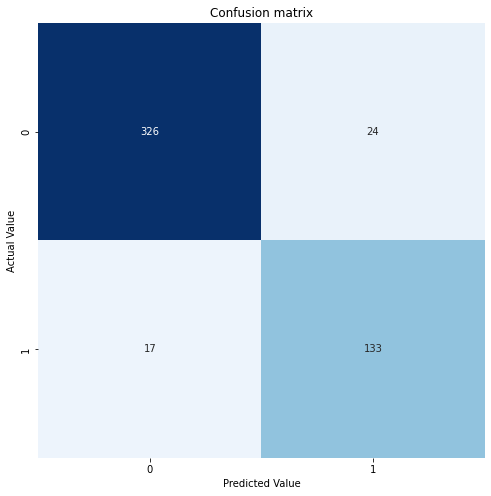

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from numpy import trapz
from scipy.integrate import simps
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score,cohen_kappa_score

def Evaluate(labels, predictions, p=0.5):
    CM= confusion_matrix(labels, predictions > p)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    print(' (True Negatives): {}'.format(TN))
    print(' (False Negatives):  {}'.format(FN))
    print(' (True Positives): {}'.format(TP))
    print('(False Positives):{}'.format(FP))
    print('Total positive : ', np.sum(CM[1]))
    auc = roc_auc_score(labels, predictions)
    prec=precision_score(labels, predictions>0.5)
    rec=recall_score(labels, predictions>0.5)
     # calculate F1 score
    f1 = f1_score(labels, predictions>p)
    print('auc :{}'.format(auc))
    print('precision :{}'.format(prec))
    print('recall :{}'.format(rec))
    print('f1 :{}'.format(f1))
    # Compute Precision-Recall and plot curve
    precision, recall, thresholds = precision_recall_curve(labels, predictions >0.5)
    #use the trapezoidal rule to calculate the area under the precion-recall curve
    area =  trapz(recall, precision)
   
    #area =  simps(recall, precision)
    print("Area Under Precision Recall  Curve(AP): %0.4f" % area)   #should be same as AP? 
    average_precision = average_precision_score(labels, predictions>0.5)
    print("average precision: %0.4f" % average_precision)
    kappa = cohen_kappa_score(labels, predictions>0.5)
    print('kappa :{}'.format(kappa))
    balanced_accuracy = balanced_accuracy_score(labels, predictions>0.5)
    print('balanced_accuracy :{}'.format(balanced_accuracy))

    c_matrix =confusion_matrix(labels,predictions)
    print(c_matrix)
    clr = classification_report(labels,predictions)
    print(clr)
    plt.figure(figsize=(8,8))
    sns.heatmap(c_matrix,annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.title("Confusion matrix")
    plt.show()
    
    
   
Evaluate(test_data['label'], np.asarray(pred_probs) >0.5)